In [1]:
import sys
sys.path.append('../')

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers, models
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
model_version = "v9.1"
base_model_version = 'v9.0'

In [4]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"../data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
input_shape = X_train_scaled.shape[1]

inputs = keras.Input(shape=(input_shape,))

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64')(inputs)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_128')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_256')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64_2')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.load_weights(f"../models/{base_model_version}/spec_photo_model.h5", by_name=True, skip_mismatch=True)

model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = False
model.get_layer('Dense_256').trainable = False
model.get_layer('Dense_64_2').trainable = True

model = keras.Model(inputs=inputs, outputs=outputs)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 39)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2560      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 dropout_14 (Dropout)        (None, 256)               0   

In [13]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/200
4467/4467 [==============================] - 24s 5ms/step - loss: 12.3941 - mae: 2.5636 - mse: 11.8570 - mape: 24.2290 - val_loss: 0.9913 - val_mae: 0.5754 - val_mse: 0.5017 - val_mape: 5.4745
Epoch 2/200
4467/4467 [==============================] - 22s 5ms/step - loss: 4.0836 - mae: 1.5104 - mse: 3.5945 - mape: 14.3054 - val_loss: 1.1001 - val_mae: 0.6569 - val_mse: 0.6117 - val_mape: 6.1688
Epoch 3/200
4467/4467 [==============================] - 23s 5ms/step - loss: 2.0579 - mae: 0.9928 - mse: 1.5700 - mape: 9.4431 - val_loss: 0.9325 - val_mae: 0.5267 - val_mse: 0.4450 - val_mape: 5.0637
Epoch 4/200
4467/4467 [==============================] - 22s 5ms/step - loss: 1.1220 - mae: 0.6220 - mse: 0.6347 - mape: 5.9858 - val_loss: 0.9148 - val_mae: 0.5017 - val_mse: 0.4278 - val_mape: 4.8777
Epoch 5/200
4467/4467 [==============================] - 22s 5ms/step - loss: 0.9303 - mae: 0.5092 - mse: 0.4434 - mape: 4.9539 - val_loss: 0.9150 - val_mae: 0.4960 - val_mse: 0.4285 - val

In [14]:
y_pred = model.predict(X_test_scaled)

1396/1396 [==============================] - 2s 1ms/step


In [15]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.5004
Root Mean Squared Error (RMSE): 0.6592
R² Score: 0.0020


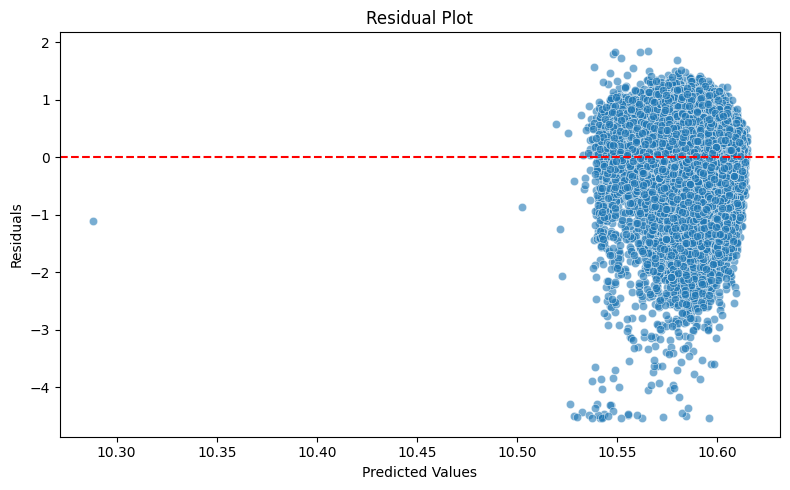

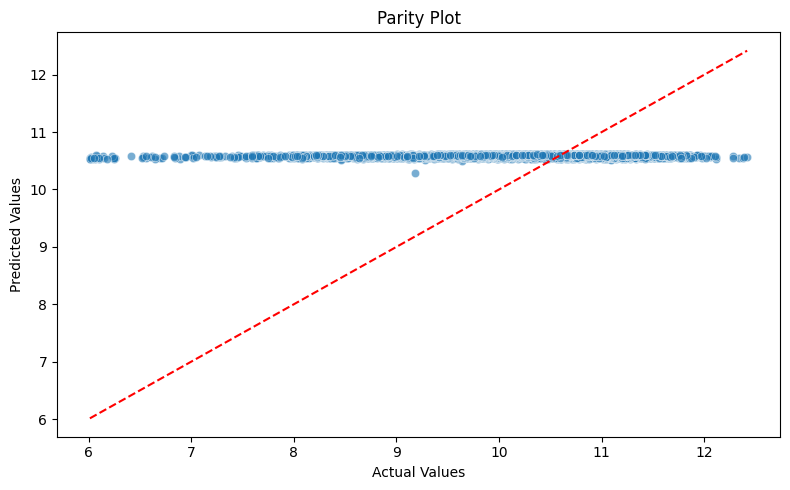

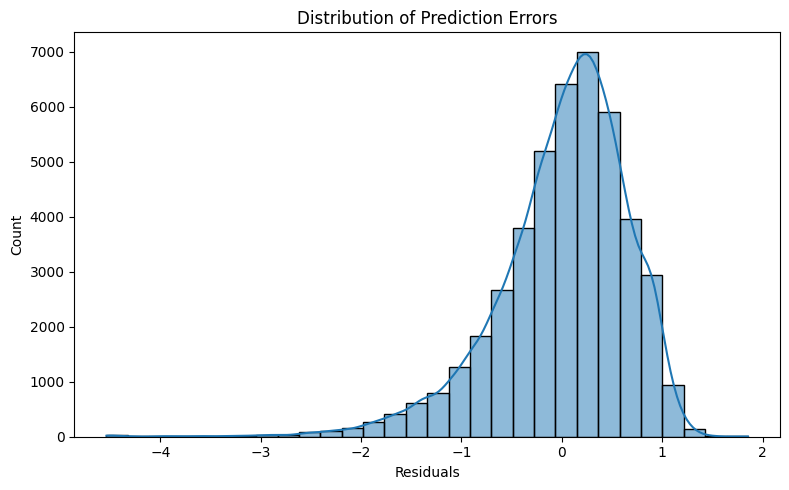

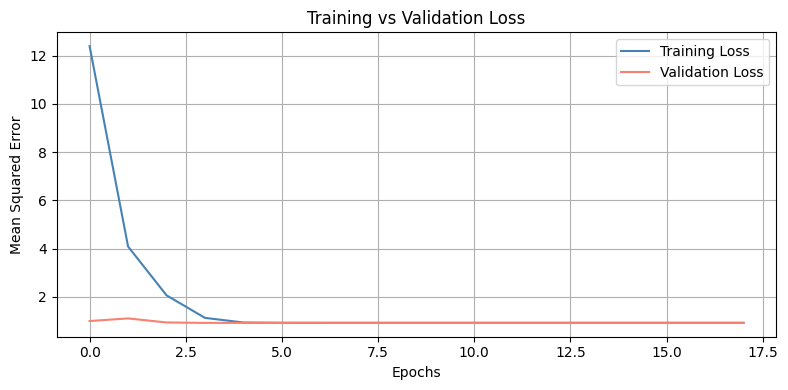

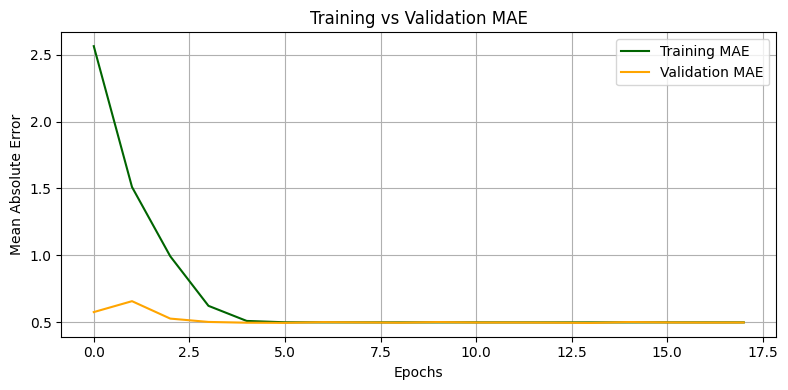

In [16]:
plot_visualizations(history, y_test, y_pred)

In [32]:
def save_model(model, model_version, model_name='spec_photo_model'):
    os.makedirs(f'models/{model_version}', exist_ok=True)
    model.save(f'models/{model_version}/{model_name}.h5')
    
def save_history(history, model_version, history_name='history'):
    os.makedirs(f'history/{model_version}', exist_ok=True)

    history_path = os.path.join(f'history/{model_version}', f'{history_name}.json')
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

In [34]:
save_history(history, model_version, 'history_photo_only')

In [35]:
save_model(transfer_model, model_version, 'photo_only_model')